# explore geometrical shapes for array design

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

import nwastats as st

In [2]:
from matplotlib.patches import FancyArrowPatch
from matplotlib.patches import Arc
from matplotlib.transforms import Bbox, IdentityTransform, TransformedBbox

class AngleAnnotation(Arc):
    """
    Draws an arc between two vectors which appears circular in display space.
    """
    def __init__(self, xy, p1, p2, size=75, unit="points", ax=None,
                 text="", textposition="inside", text_kw=None, **kwargs):
        """
        Parameters
        ----------
        xy, p1, p2 : tuple or array of two floats
            Center position and two points. Angle annotation is drawn between
            the two vectors connecting *p1* and *p2* with *xy*, respectively.
            Units are data coordinates.

        size : float
            Diameter of the angle annotation in units specified by *unit*.

        unit : str
            One of the following strings to specify the unit of *size*:

            * "pixels": pixels
            * "points": points, use points instead of pixels to not have a
              dependence on the DPI
            * "axes width", "axes height": relative units of Axes width, height
            * "axes min", "axes max": minimum or maximum of relative Axes
              width, height

        ax : `matplotlib.axes.Axes`
            The Axes to add the angle annotation to.

        text : str
            The text to mark the angle with.

        textposition : {"inside", "outside", "edge"}
            Whether to show the text in- or outside the arc. "edge" can be used
            for custom positions anchored at the arc's edge.

        text_kw : dict
            Dictionary of arguments passed to the Annotation.

        **kwargs
            Further parameters are passed to `matplotlib.patches.Arc`. Use this
            to specify, color, linewidth etc. of the arc.

        """
        self.ax = ax or plt.gca()
        self._xydata = xy  # in data coordinates
        self.vec1 = p1
        self.vec2 = p2
        self.size = size
        self.unit = unit
        self.textposition = textposition

        super().__init__(self._xydata, size, size, angle=0.0,
                         theta1=self.theta1, theta2=self.theta2, **kwargs)

        self.set_transform(IdentityTransform())
        self.ax.add_patch(self)

        self.kw = dict(ha="center", va="center",
                       xycoords=IdentityTransform(),
                       xytext=(0, 0), textcoords="offset points",
                       annotation_clip=True)
        self.kw.update(text_kw or {})
        self.text = ax.annotate(text, xy=self._center, **self.kw)

    def get_size(self):
        factor = 1.
        if self.unit == "points":
            factor = self.ax.figure.dpi / 72.
        elif self.unit[:4] == "axes":
            b = TransformedBbox(Bbox.unit(), self.ax.transAxes)
            dic = {"max": max(b.width, b.height),
                   "min": min(b.width, b.height),
                   "width": b.width, "height": b.height}
            factor = dic[self.unit[5:]]
        return self.size * factor

    def set_size(self, size):
        self.size = size

    def get_center_in_pixels(self):
        """return center in pixels"""
        return self.ax.transData.transform(self._xydata)

    def set_center(self, xy):
        """set center in data coordinates"""
        self._xydata = xy

    def get_theta(self, vec):
        vec_in_pixels = self.ax.transData.transform(vec) - self._center
        return np.rad2deg(np.arctan2(vec_in_pixels[1], vec_in_pixels[0]))

    def get_theta1(self):
        return self.get_theta(self.vec1)

    def get_theta2(self):
        return self.get_theta(self.vec2)

    def set_theta(self, angle):
        pass

    # Redefine attributes of the Arc to always give values in pixel space
    _center = property(get_center_in_pixels, set_center)
    theta1 = property(get_theta1, set_theta)
    theta2 = property(get_theta2, set_theta)
    width = property(get_size, set_size)
    height = property(get_size, set_size)

    # The following two methods are needed to update the text position.
    def draw(self, renderer):
        self.update_text()
        super().draw(renderer)

    def update_text(self):
        c = self._center
        s = self.get_size()
        angle_span = (self.theta2 - self.theta1) % 360
        angle = np.deg2rad(self.theta1 + angle_span / 2)
        r = s / 2
        if self.textposition == "inside":
            r = s / np.interp(angle_span, [60, 90, 135, 180],
                                          [3.3, 3.5, 3.8, 4])
        self.text.xy = c + r * np.array([np.cos(angle), np.sin(angle)])
        if self.textposition == "outside":
            def R90(a, r, w, h):
                if a < np.arctan(h/2/(r+w/2)):
                    return np.sqrt((r+w/2)**2 + (np.tan(a)*(r+w/2))**2)
                else:
                    c = np.sqrt((w/2)**2+(h/2)**2)
                    T = np.arcsin(c * np.cos(np.pi/2 - a + np.arcsin(h/2/c))/r)
                    xy = r * np.array([np.cos(a + T), np.sin(a + T)])
                    xy += np.array([w/2, h/2])
                    return np.sqrt(np.sum(xy**2))

            def R(a, r, w, h):
                aa = (a % (np.pi/4))*((a % (np.pi/2)) <= np.pi/4) + \
                     (np.pi/4 - (a % (np.pi/4)))*((a % (np.pi/2)) >= np.pi/4)
                return R90(aa, r, *[w, h][::int(np.sign(np.cos(2*a)))])

            bbox = self.text.get_window_extent()
            X = R(angle, r, bbox.width, bbox.height)
            trans = self.ax.figure.dpi_scale_trans.inverted()
            offs = trans.transform(((X-s/2), 0))[0] * 72
            self.text.set_position([offs*np.cos(angle), offs*np.sin(angle)])

In [8]:
def spiral_archimedean(n, a, dtheta, theta0=0., x0=0., y0=0.):
    theta = np.arange(0,n)*dtheta
    z = a*theta/(2*np.pi) * np.exp(1j*(theta+theta0))
    z0 = x0 + 1j*y0
    return z0 + z


n, a = 8, 100
n, a = 16, 100
#dtheta = np.pi/2
dtheta = np.pi/3 #* 1.1
#theta0 = 0.
theta0 = np.pi/3

# adjust a to specify max distance
L = 200
if n==2:
    a = L*2*np.pi/dtheta
elif n>2:
    a = L/(n-2)*np.pi/dtheta
print(a)

za = spiral_archimedean(n, a, dtheta, theta0=theta0)
za_h = spiral_archimedean(n*100, a, dtheta/100, theta0=theta0)

42.85714285714286


192.85714285714283


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


scp dunree:/home1/datawork/aponte/code/nwastats/notebooks/figs/matern52_iso_array_spiral.eps .
scp dunree:/home1/datawork/aponte/code/nwastats/notebooks/figs/matern52_iso_array_spiral.png .


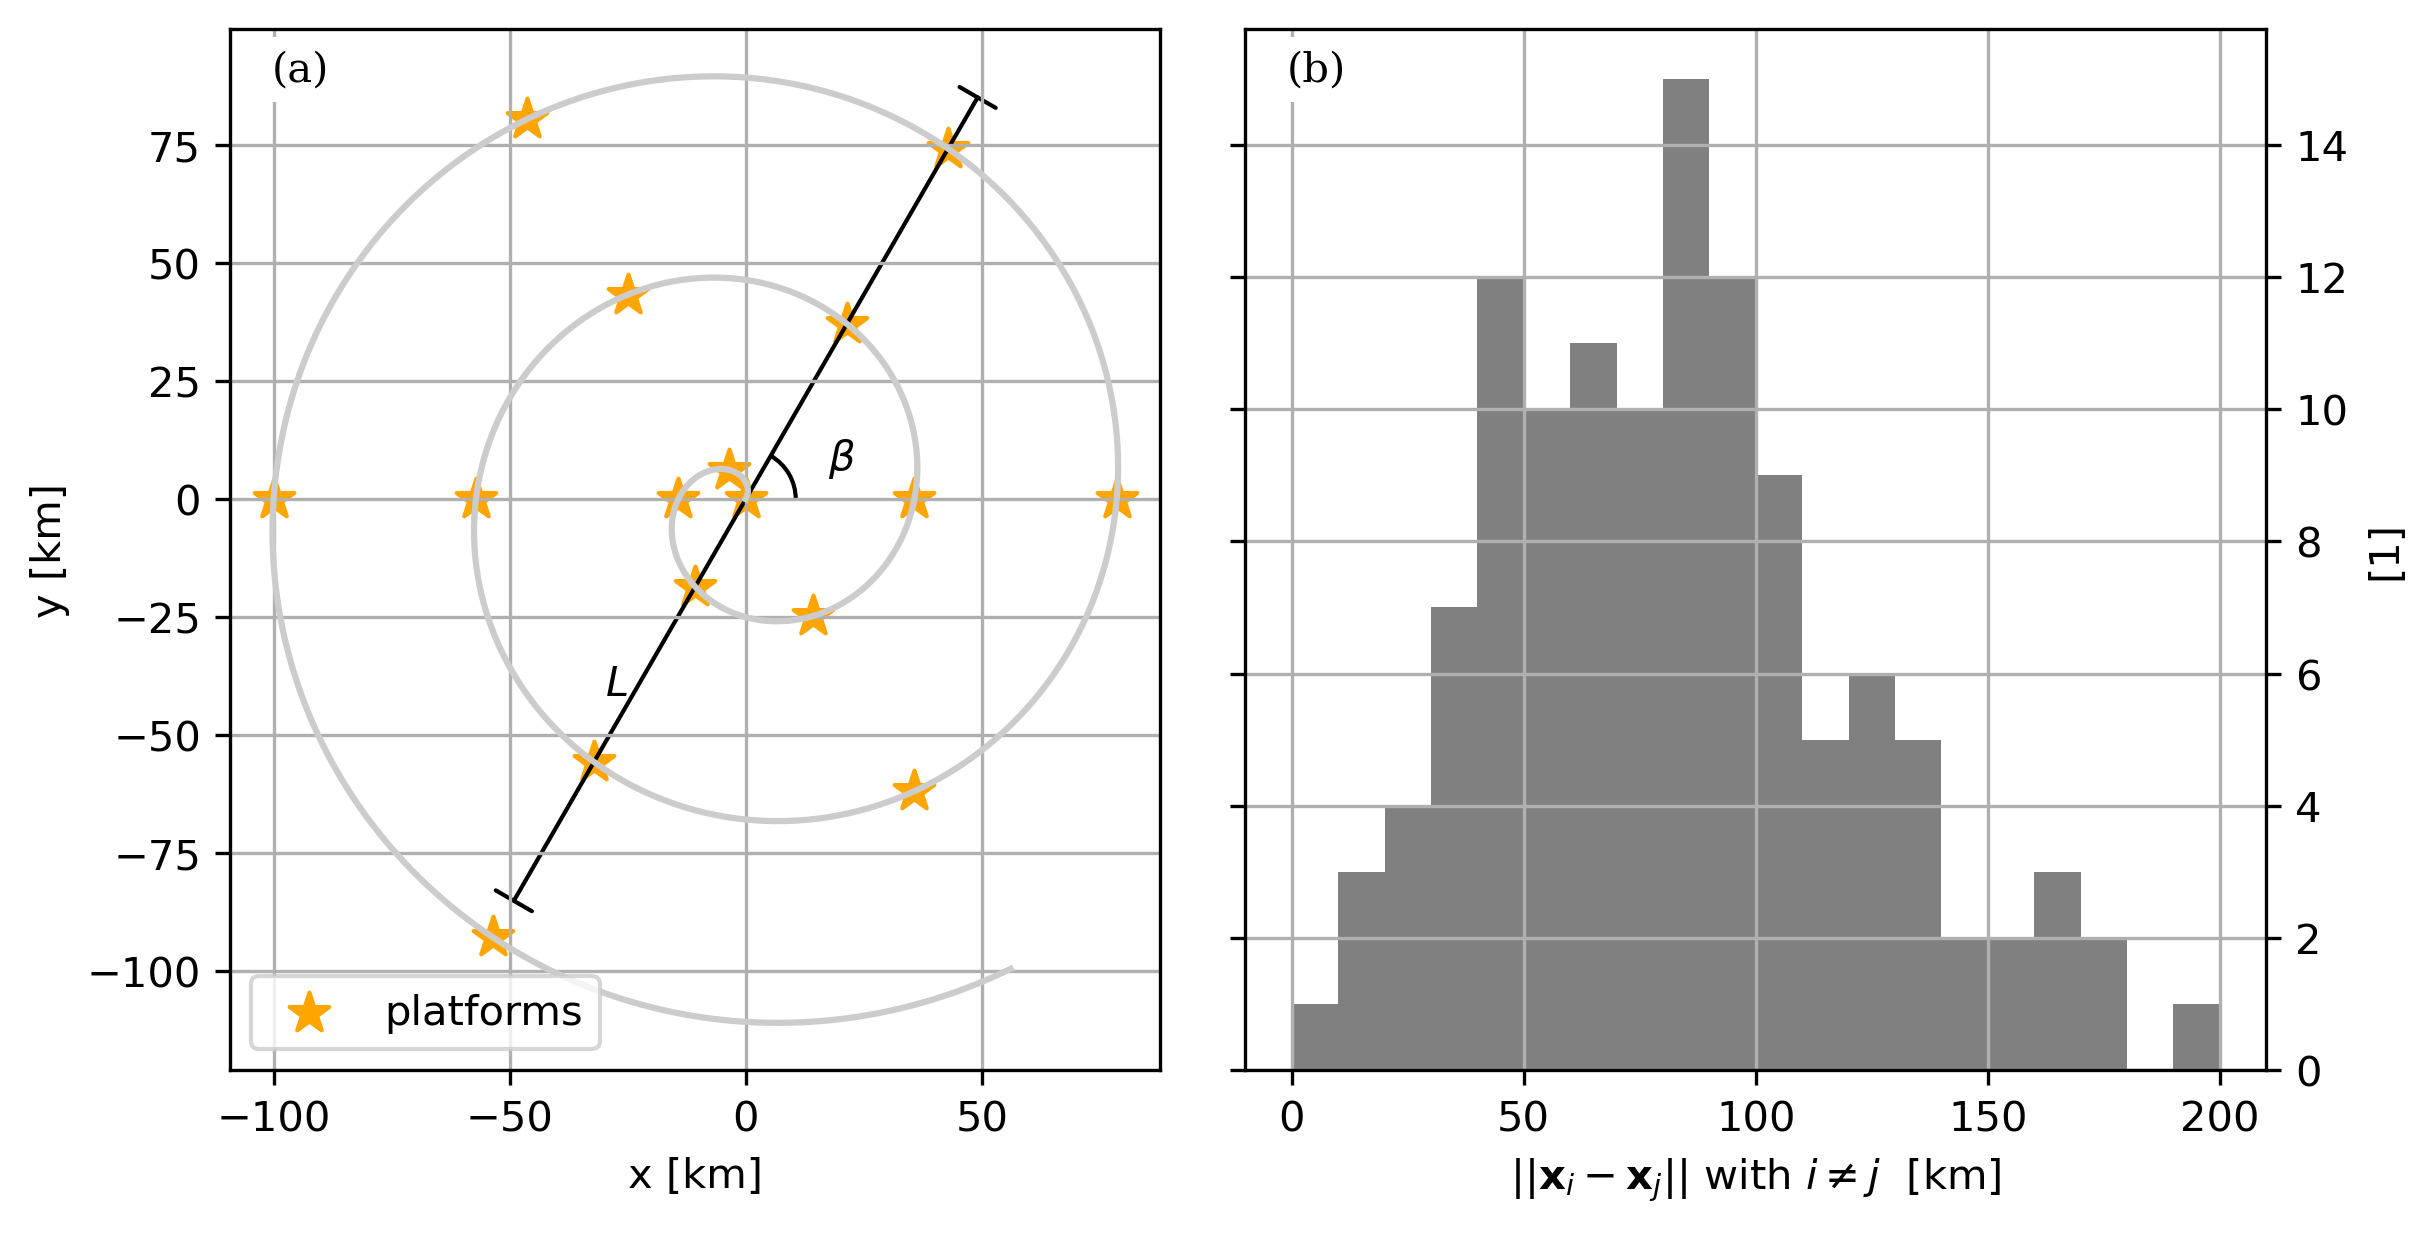

In [9]:
#fig, axes = plt.subplots(1,2, figsize=(7,3))
fig, axes = plt.subplot_mosaic(
    [['(a)', '(b)',]],
    layout='constrained',
    figsize=(8,4),
    dpi=300,
)


ax = axes['(a)']
ax.plot(np.real(za_h), np.imag(za_h), color="0.8")
ax.scatter(np.real(za), np.imag(za), c="orange", s=100, marker="*", label="platforms")
ax.set_aspect("equal")
ax.grid()
ax.legend()
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")

angle = 0
style = '|-|'
cos, sin = np.cos(theta0), np.sin(theta0)
arrow_centers = ((L*cos/2, L*sin/2), (-L*cos/2, -L*sin/2))
anglesAB = (angle, -angle)
bracketstyle = f"{style}, angleA={anglesAB[0]}, angleB={anglesAB[1]}"
bracket = FancyArrowPatch(*arrow_centers, arrowstyle=bracketstyle,
                          mutation_scale=5)
ax.add_patch(bracket)
ax.text( -L*cos/2/2, -L*sin/2/2 , r"$L$", ha="right", va="bottom")

center = (0,0)
r = 1/2
p1 = (L*r, 0)
p2 = (L*r*cos, L*r*sin)
am1 = AngleAnnotation(center, p1, p2, ax=ax, size=100, text=r"$\beta$", text_kw=dict(ha="right", va="top")) #, textposition="inside")

ax = axes['(b)']
d = [np.abs(za[i]-za[j]) for i, j in combinations(np.arange(n), 2)]
ax.hist(d, bins=np.arange(0, L+10, 10), color="0.5")
print(max(d))
#bins, h = np.histogram(d, bins=np.arange(0,400,10))
ax.set_xlabel(r"$||\mathbf{x}_i - \mathbf{x}_j||$ with $i\neq j$  [km]")
ax.set_ylabel(r"[1]")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position('both')
ax.yaxis.set_label_position("right")
ax.grid()

#plt.tight_layout()

st.label_and_print(fig, axes, 'matern52_iso'+"_array_spiral")